# Data Interpretation 

In [1]:
filename="data/textfiles/Flickr8k.token.txt"
file=open(filename,"r")
doc=file.read()

In [169]:
doc.split("\n")[:3]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

In [42]:
descriptions= dict()
image_ids=set()
i=0
for line in doc.split("\n"):
    image_id=line.split("\t")[0][:-6]
    if image_id not in image_ids:
        descriptions[image_id]=list()
        image_ids.add(image_id)
    if i<5 and len(line.split("\t")) >1:
        descriptions[image_id].append(line.split("\t")[1])
        i+=1
    if i>=5:
        i=0

In [44]:
len(descriptions)

8093

Preprocessing of text

In [46]:
import string
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
    
        desc = desc.split()
     
        desc = [word.lower() for word in desc]
     
        desc = [w.translate(table) for w in desc]
    
        desc = [word for word in desc if len(word)>1]

        desc = [word for word in desc if word.isalpha()]
        desc_list[i] =  ' '.join(desc)

In [49]:
descriptions["1024138940_f1fefbdce1"]

['two different breeds of brown and white dogs play on the beach',
 'two dogs are making turn on soft sand beach',
 'two dogs playing in the sand at the beach',
 'two dogs playing together on beach',
 'two large tan dogs play along sandy beach']

In [55]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]

In [58]:
len(vocab)

8763

In [61]:
all_captions=[]
for key ,value in descriptions.items():
    for cap in value:
        all_captions.append(cap)

word_count_threshold=10
word_count ={}

for caption in all_captions:
    for word in caption.split():
        word_count[word]=word_count.get(word,0)+1
        
vocab=[word for word in word_count.keys() if word_count[word]>=word_count_threshold]

In [63]:
len(vocab)

1947

In [64]:
filename="data/textfiles/Flickr_8k.trainImages.txt"
file=open(filename, 'r')
doc=file.read()

In [66]:
train=[]
for line in doc.split("\n"):
    train.append(line.split(".")[0])
print(len(train))

6001


In [67]:
train_description={}
for name in train:
    train_description[name]=[]
    for caption in descriptions[name]:
        train_description[name].append("startseq "+caption+" endseq")
        
len(train_description)

6001

In [68]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

C:\Users\HP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Image_preprocessing

In [69]:
def preprocess(imagepath):
    img=image.load_img(imagepath ,target_size=(299,299))
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    x=preprocess_input(x)
    return x

model for encoding images

In [71]:
model=InceptionV3(weights='imagenet')
model.summary()

96116736/96112376 [==============================] - 176s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________

In [72]:
new_model=Model(model.input ,model.layers[-2].output)
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [93]:
def encode(image):
    image=preprocess(image)
    feature_vec=new_model.predict(image)
    feature_vec=np.reshape(feature_vec ,feature_vec.shape[1])
    return feature_vec

In [128]:
images = 'data/images/'
img = glob.glob(images + '*.jpg')
img
train_images_file = 'data/textfiles/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img:
    if i[len(images):] in train_images: 
        train_img.append(i)
        
len(train_img)

6000

In [135]:
test_images_file =  'data/textfiles/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

In [136]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in minutes =", (time()-start)/60)
len(encoding_train)

Time taken in minutes = 145.87037596702575


6000

In [137]:
with open("data/pickle/encoded_train_images.pkl","wb") as encoded_pickle :
    dump(encoding_train, encoded_pickle)

In [100]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in minutes =", (time()-start)/60)

Time taken in minutes = 379.0032661676407


In [101]:
with open("data/pickle/encoded_test_images.pkl","wb") as encoded_pickle :
    dump(encoding_test, encoded_pickle)

In [106]:
ixtoword={}
wordtoix={}

ix=1
for word in vocab:
    ixtoword[ix]=word
    wordtoix[word]=ix
    ix+=1

In [107]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1948

In [109]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_description)
print('Description Length: %d' % max_length)

Description Length: 34


In [110]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [115]:
f=open("data/glove/glove.6B.200d.txt" ,encoding="utf-8")
embedding_index={}
for line in f:
    values= line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coefs
    
f.close()
print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


Embedding for our vocab

In [117]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [118]:
embedding_matrix.shape

(1948, 200)

Final Model for prediction

In [119]:
input1=Input(shape=(2048,))
fe1=Dropout(0.5)(input1)
fe2=Dense(256,activation="relu")(fe1)

input2=Input(shape=(max_length,))
se1=Embedding(vocab_size ,embedding_dim ,mask_zero=True)(input2)
se2=Dropout(0.5)(se1)
se3=LSTM(256)(se2)

decoder1 =add([fe2,se3])
decoder2=Dense(256 ,activation="relu")(decoder1)
outputs=Dense(vocab_size ,activation="softmax")(decoder2)

model=Model(inputs=[input1,input2],outputs=outputs)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      389600      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_2 

inserting embeddings in  model

In [120]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [123]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_description)//number_pics_per_bath

In [139]:
train_features = load(open("data/pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


Training Model

In [145]:
for i in range(6):
    generator = data_generator(train_description, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('data/model_weights/model_' + str(i) + '.h5')    

Epoch 1/1
2000/2000 [==============================] - 1487s 744ms/step - loss: 3.4068
Epoch 1/1
2000/2000 [==============================] - 1455s 727ms/step - loss: 3.2496
Epoch 1/1
2000/2000 [==============================] - 1057s 528ms/step - loss: 3.1312
Epoch 1/1
2000/2000 [==============================] - 927s 463ms/step - loss: 3.0416
Epoch 1/1
2000/2000 [==============================] - 933s 467ms/step - loss: 2.9705
Epoch 1/1
2000/2000 [==============================] - 935s 468ms/step - loss: 2.9099


In [146]:
model.load_weights('data/model_weights/model_5.h5')

In [153]:
images = 'data/images/'

In [148]:
with open("data/pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

We will folow greedy approach for next word generation what is the best possibility until we find a endseq

In [166]:
def greedySearch(photo):
    in_text = 'startseq '
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == ' endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

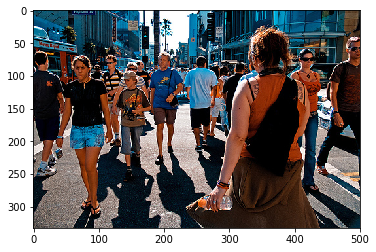

Greedy: in the street with traffic in the background and people are walking in the street and one of them is walking past the street and traffic in the background watch her shoulders on


In [168]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))